# This notebook explores PINNs using the example of a projectile motion  
More information about this can be found at: https://towardsdatascience.com/physics-informed-neural-networks-pinns-an-intuitive-guide-fff138069563

## Equation considered:
We consider projectile motion with the following (drag + gravity) acceleration:
$$ \vec{a} = -\frac{c}{m} \|\vec{v}\| \vec{v} - \vec{g}$$

There exists no closed-form solution for the displacement in this system and numerical integration methods like the Runge-Kutta methods are used.



## How to consider this equation in the model:
We can simply add a loss term to the model to respect our second order differential term in a similar way to using Lagrangian multipliers:
$$ \mathcal{L} = (MSE.term) + \frac{1}{n} \sum\limits_{i=1}^n \left( \frac{d^2 f_i}{dt_i^2} + \vec{g} + \frac{c}{m} \|\frac{df_i}{dt_i}\|\frac{df_i}{dt_i} \right)$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn

In [3]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

## Generating the dataset using Runge-Kutta method

In [4]:
# Constants
g = 9.81  # gravitational acceleration (m/s^2)
m = 0.5  # mass of the projectile (kg)
c = 0.1  # drag coefficient (kg/s)

In [5]:
# Time settings
dt = 0.05  # time step (s)
T_MAX = 10.  # maximum simulation time (s)
N_TIME_STEPS = T_MAX/dt

In [6]:
# Initial conditions
v0 = 50.0  # initial speed (m/s)
angle = 10.0  # launch angle (degrees)
vx0 = v0 * np.cos(np.radians(angle))  # initial velocity in x-direction
vy0 = v0 * np.sin(np.radians(angle))  # initial velocity in y-direction
r0 = np.array([0.0, 0.0])  # initial position (m)
v0 = np.array([vx0, vy0])  # initial velocity (m/s)

In [7]:
# Function to compute derivatives
def derivatives(r, v):
    speed = np.linalg.norm(v)
    drag = (c / m) * speed * v
    a = np.array([0, -g]) - drag
    return a

In [8]:
# Runge-Kutta 4th order method
def rk4(r, v, dt):
    k1r = v
    k1v = derivatives(r, v)
    
    k2r = v + 0.5 * dt * k1v
    k2v = derivatives(r + 0.5 * dt * k1r, v + 0.5 * dt * k1v)
    
    k3r = v + 0.5 * dt * k2v
    k3v = derivatives(r + 0.5 * dt * k2r, v + 0.5 * dt * k2v)
    
    k4r = v + dt * k3v
    k4v = derivatives(r + dt * k3r, v + dt * k3v)
    
    r_next = r + (dt / 6.0) * (k1r + 2*k2r + 2*k3r + k4r)
    v_next = v + (dt / 6.0) * (k1v + 2*k2v + 2*k3v + k4v)
    
    return r_next, v_next

In [9]:
# Lists to store the trajectory
trajectory_r = [r0]
trajectory_v = [v0]
t = 0.0

# Simulation loop
while t < T_MAX and r0[1] >= 0.0:  # continue until the projectile hits the ground
    r_next, v_next = rk4(r0, v0, dt)
    trajectory_r.append(r_next)
    trajectory_v.append(v_next)
    r0, v0 = r_next, v_next
    t += dt

if r0[1] <= 0.0:
    print("Hit the ground at time: ", t)

# Convert trajectory lists to numpy arrays
trajectory_r = np.array(trajectory_r)
trajectory_v = np.array(trajectory_v)




Hit the ground at time:  0.8500000000000002


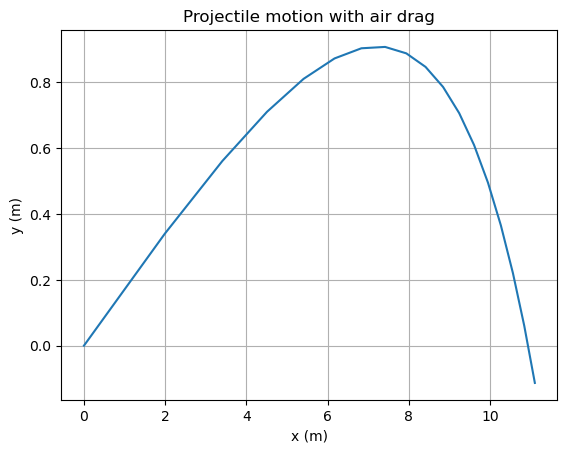

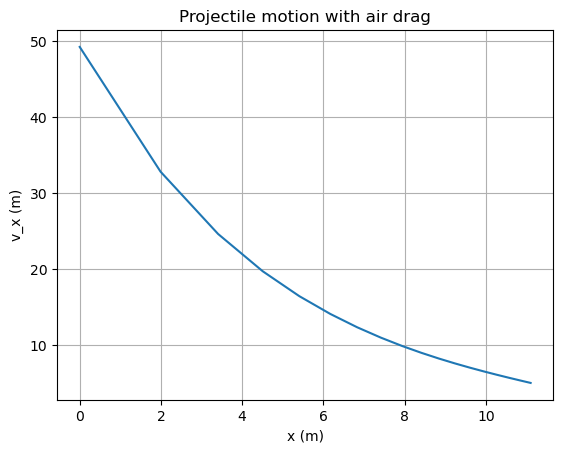

In [10]:
# Plotting the trajectory
plt.plot(trajectory_r[:, 0], trajectory_r[:, 1])
plt.title('Projectile motion with air drag')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.grid()
plt.show()

# Plotting the trajectory
plt.plot(trajectory_r[:, 0], trajectory_v[:, 0])
plt.title('Projectile motion with air drag')
plt.xlabel('x (m)')
plt.ylabel('v_x (m)')
plt.grid()
plt.show()

## Generating the dataset

In [11]:
N_POINTS = 1

In [12]:
data_r = np.array([[]])
data_v = np.array([[]])

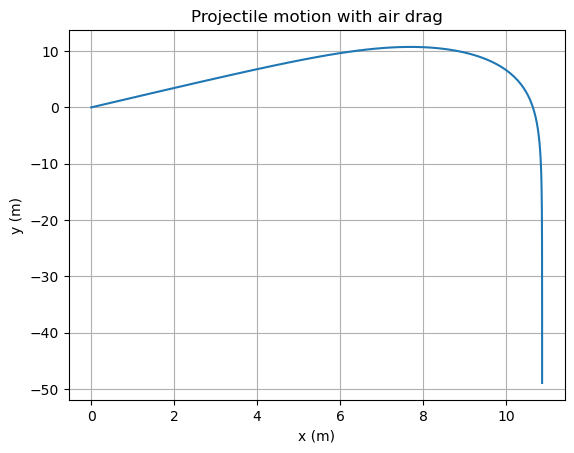

In [29]:
for i in range(N_POINTS):
    # Initial conditions
    v0 = np.random.uniform(0, 100)  # initial speed (m/s)
    v0 = 100
    angle = np.random.uniform(0, 90)  # launch angle (degrees)

    angle = 60
    vx0 = v0 * np.cos(np.radians(angle))  # initial velocity in x-direction
    vy0 = v0 * np.sin(np.radians(angle))  # initial velocity in y-direction
    r0 = np.array([0.0, 0.0])  # initial position (m)
    v0 = np.array([vx0, vy0])  # initial velocity (m/s)

    # Lists to store the trajectory
    trajectory_r = [r0]
    trajectory_v = [v0]
    x_data = np.array([r0[0]])
    y_data = np.array([r0[1]])
    vx_data = np.array([v0[0]])
    vy_data = np.array([v0[1]])
    t = 0.0

    # Simulation loop
    while t < T_MAX: # and r0[1] >= 0.0:  # continue until the projectile hits the ground
        r_next, v_next = rk4(r0, v0, dt)
        trajectory_r.append(r_next)
        trajectory_v.append(v_next)
        x_data = np.append(x_data, r0[0])
        y_data = np.append(y_data, r0[1])
        vx_data = np.append(vx_data, v0[0])
        vy_data = np.append(vy_data, v0[1])
        data_v = np.append(data_v, v0)

        r0, v0 = r_next, v_next
        t += dt

    # if r0[1] <= 0.0:
    #     print("Hit the ground at time: ", t)

    # Convert trajectory lists to numpy arrays
    trajectory_r = np.array(trajectory_r)
    trajectory_v = np.array(trajectory_v)

    # Plotting the trajectory
    plt.plot(trajectory_r[:, 0], trajectory_r[:, 1])
    plt.title('Projectile motion with air drag')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.grid()
    plt.show()


## PINN part

In [35]:
# Define the neural network
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(3, 20),  # Input: t, x, y
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 2)   # Output: vx, vy
        )

    def forward(self, t, x, y):
        # print(t.shape, x.shape, y.shape)
        return self.hidden(torch.stack([t, x, y], dim=1))


In [36]:
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [37]:
# Loss function
def loss_function(t, x, y, vx, vy):

    vx_pred, vy_pred = model(t[:-1], x[:-1], y[:-1]).T

    # print(vx_pred.shape)

    speed = torch.sqrt(vx_pred**2 + vy_pred**2)
    
    d2f_dt2_x = (vx_pred[:-1] - vx_pred[1:])/dt
    d2f_dt2_y = (vy_pred[:-1] - vy_pred[1:])/dt

    drag_x = (c / m) * speed[1:] * vx_pred[1:]
    drag_y = (c / m) * speed[1:] * vy_pred[1:]

    L_MSE = ((vx_pred - vx[1:])**2).mean() + ((vy_pred - vy[1:])**2).mean()
    L_phy = ((d2f_dt2_x + drag_x)**2).mean() + ((d2f_dt2_y + g + drag_y)**2).mean()

    return L_MSE + L_phy*.01


Epoch 0, Loss: 120.46017456054688


C:\Users\srish\AppData\Local\Temp\ipykernel_30356\917613614.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_data = torch.tensor(x_data, dtype=torch.float32)
C:\Users\srish\AppData\Local\Temp\ipykernel_30356\917613614.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_data = torch.tensor(y_data, dtype=torch.float32)
C:\Users\srish\AppData\Local\Temp\ipykernel_30356\917613614.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vx_data = torch.tensor(vx_data, dtype=torch.float32)
C:\Users\srish\AppData\Local\Temp\ipykernel_30356\9

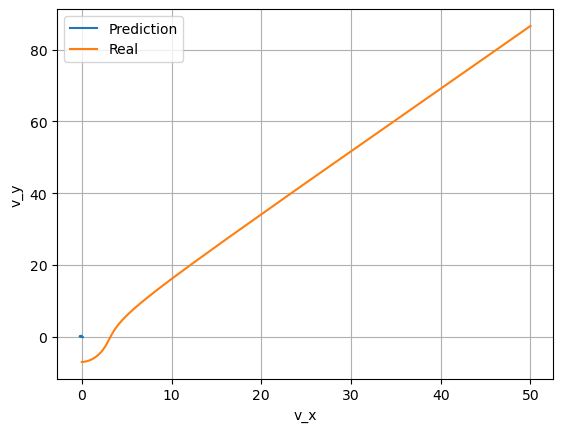

Epoch 500, Loss: 54.99057388305664


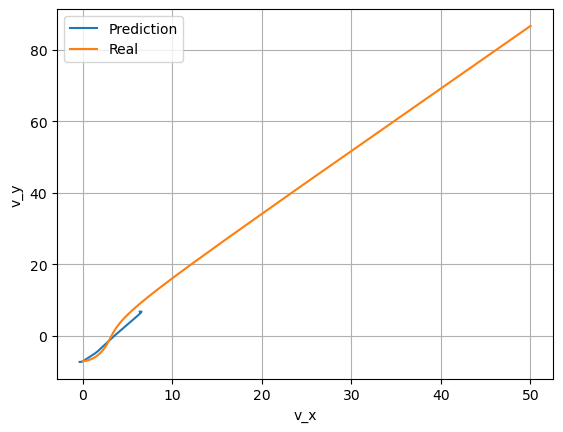

Epoch 1000, Loss: 44.9840087890625


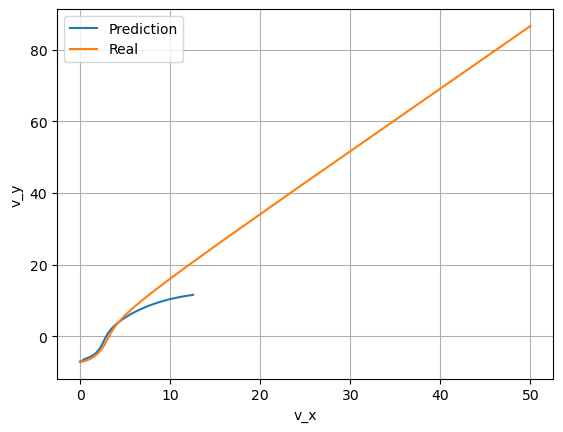

Epoch 1500, Loss: 39.52638244628906


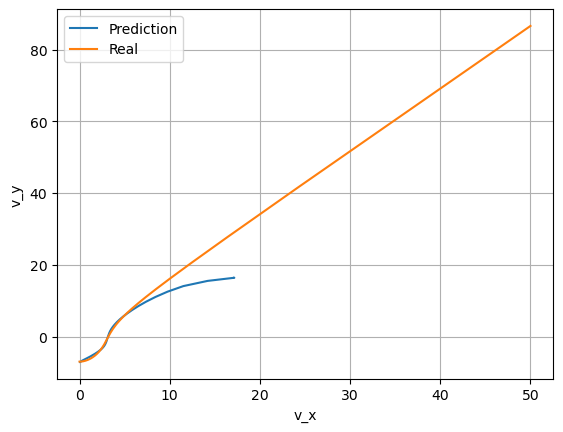

Epoch 2000, Loss: 37.08491516113281


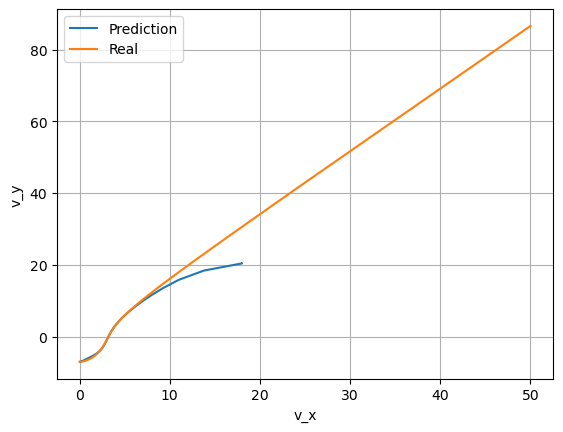

Epoch 2500, Loss: 35.89573287963867


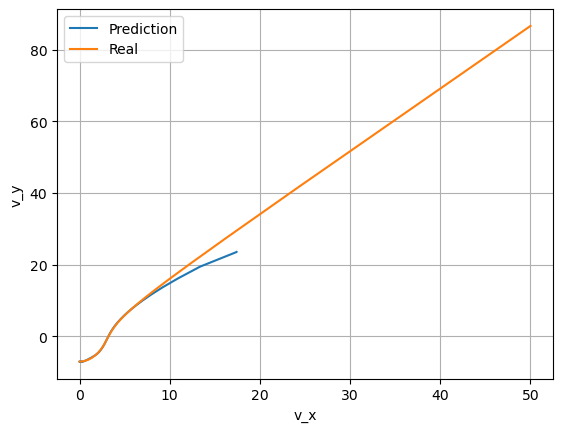

Epoch 3000, Loss: 35.4517822265625


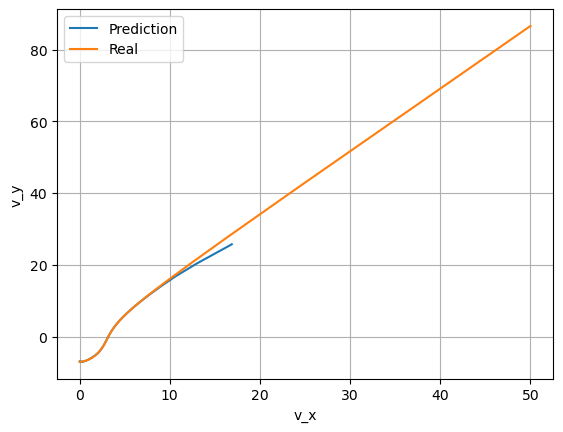

Epoch 3500, Loss: 35.345157623291016


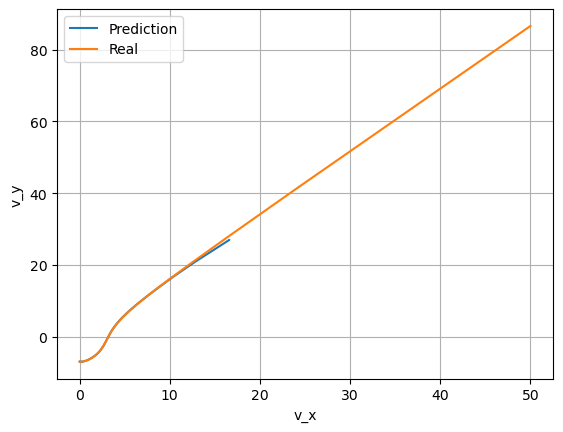

Epoch 4000, Loss: 35.32999801635742


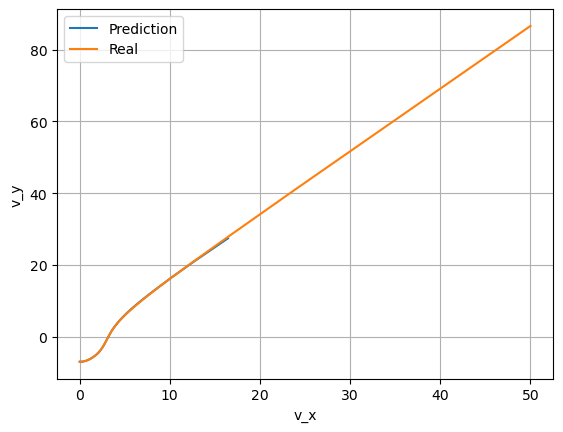

Epoch 4500, Loss: 35.32872009277344


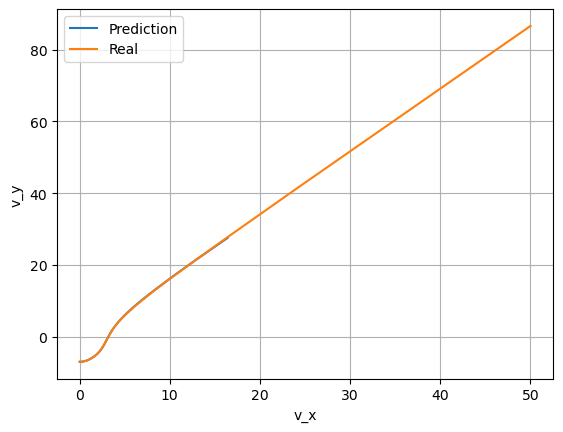

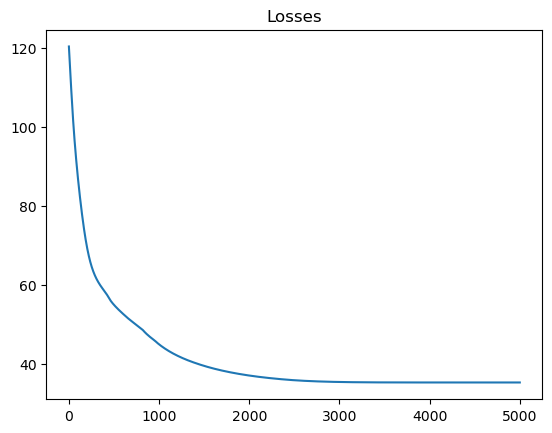

In [38]:
# Training data (initial conditions)
# t_data = torch.tensor([[0.0]], dtype=torch.float32)
# x_data = torch.tensor([[0.0]], dtype=torch.float32)
# y_data = torch.tensor([[0.0]], dtype=torch.float32)
# vx_data = torch.tensor([[vx0]], dtype=torch.float32)
# vy_data = torch.tensor([[vy0]], dtype=torch.float32)

t_data = torch.tensor(np.arange(0.0, T_MAX+dt, dt), dtype=torch.float32)
x_data = torch.tensor(x_data, dtype=torch.float32)
y_data = torch.tensor(y_data, dtype=torch.float32)
vx_data = torch.tensor(vx_data, dtype=torch.float32)
vy_data = torch.tensor(vy_data, dtype=torch.float32)

# Training loop
num_epochs = 5000
losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_function(t_data, x_data, y_data, vx_data, vy_data)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())


    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

        with torch.no_grad():
            vx_pred, vy_pred = model(t_data[:-1], x_data[:-1], y_data[:-1]).T
            plt.plot(vx_pred, vy_pred)
            plt.plot(vx_data, vy_data)
            plt.legend(["Prediction", "Real"])
            plt.xlabel("v_x")
            plt.ylabel("v_y")
            plt.grid()
            plt.show()


plt.plot(losses)
plt.title("Losses")
plt.show()

In [39]:
# # Initial conditions
# v0 = 50.0  # initial speed (m/s)
# angle = 45.0  # launch angle (degrees)
# vx0 = v0 * np.cos(np.radians(angle))  # initial velocity in x-direction
# vy0 = v0 * np.sin(np.radians(angle))  # initial velocity in y-direction
# r0 = np.array([0.0, 0.0])  # initial position (m)
# v0 = np.array([vx0, vy0])  # initial velocity (m/s)


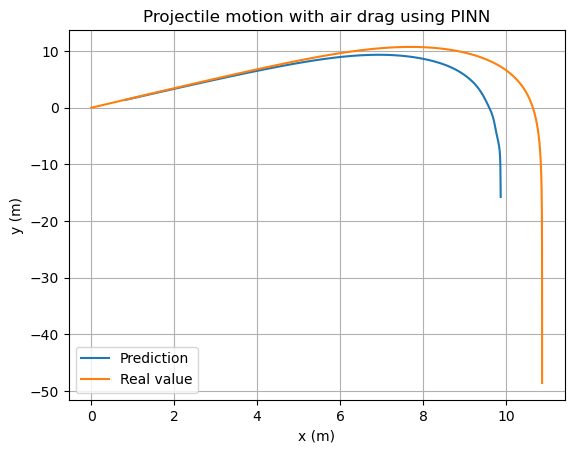

In [40]:
# Generate data for plotting
t = torch.tensor([0.0], dtype=torch.float32)
x_t = torch.tensor([0.0], dtype=torch.float32)
y_t = torch.tensor([0.0], dtype=torch.float32)

x_arr = []
y_arr = []

with torch.no_grad():
    for i in range(100):
        vx, vy = model(t, x_t, y_t).T
        # print(t_values.shape)

        t += dt
        x_t += dt * vx
        y_t += dt * vy
        
        x_arr.append(x_t.item())
        y_arr.append(y_t.item())
        # x_traj = x_values + t_values * vx_values
        # y_traj = y_values + t_values * vy_values

# Plotting the trajectory
plt.plot(x_arr, y_arr)
plt.plot(x_data.detach().numpy(), y_data.detach().numpy())
plt.title('Projectile motion with air drag using PINN')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.legend(["Prediction", "Real value"])
plt.grid()
plt.show()